In [157]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [158]:
file_path = "data\\hands2D.mat"
x=0
with h5py.File(file_path, 'r') as mat_file:
    for key in mat_file.keys():
        print(f"Dataset: {key}, Shape: {mat_file[key].shape}")
        x=mat_file[key].shape[0]
    print(mat_file.keys())

Dataset: shapes, Shape: (40, 56, 2)
<KeysViewHDF5 ['shapes']>


In [159]:
file_path = "data\\hands2D.mat"
pointsets=[]
with h5py.File(file_path, 'r') as mat_file:
    data = mat_file['shapes']
    for p in data:
        pointsets.append(np.array(p).T)

In [160]:
print(len(pointsets))
print(pointsets[0].shape)

40
(2, 56)


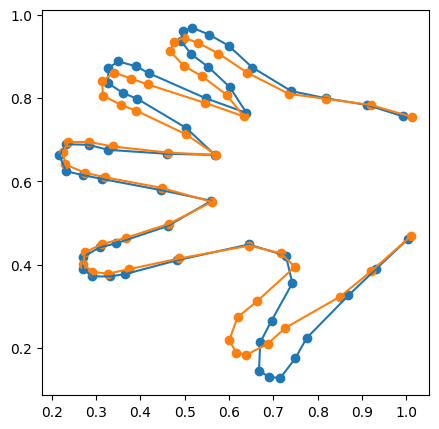

In [161]:
plt.figure(figsize=(5, 5))
plt.plot(pointsets[0][0], pointsets[0][1])
plt.scatter(pointsets[0][0], pointsets[0][1])
plt.plot(pointsets[1][0], pointsets[1][1])
plt.scatter(pointsets[1][0], pointsets[1][1])

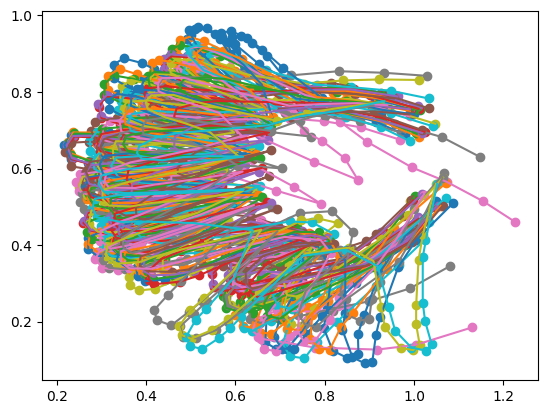

In [162]:
for i in range(40):
    # plt.figure(figsize=(5, 5))
    plt.plot(pointsets[i][0], pointsets[i][1])
    plt.scatter(pointsets[i][0], pointsets[i][1])

Text(0.5, 1.0, 'Pointset 2')

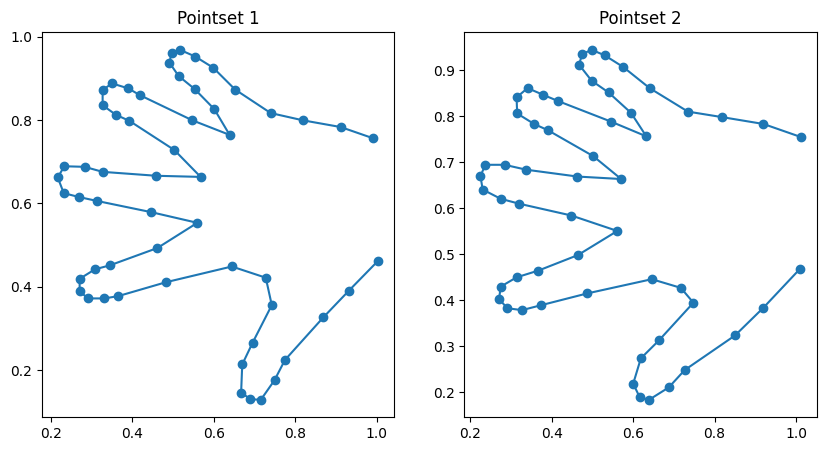

In [163]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(pointsets[0][0], pointsets[0][1])
plt.scatter(pointsets[0][0], pointsets[0][1])
plt.title('Pointset 1')

plt.subplot(1, 2, 2)
plt.plot(pointsets[1][0], pointsets[1][1])
plt.scatter(pointsets[1][0], pointsets[1][1])
plt.title('Pointset 2')

In [184]:
#Finding the karcher mean__CODE22
def centroid_normalize(shape):
    centered_shape = shape - np.mean(shape, axis=1, keepdims=True)
    norm = np.linalg.norm(centered_shape,'fro')
    normalized_shape = centered_shape / norm if norm != 0 else centered_shape
    # print(normalized_shape.shape)
    return normalized_shape

def best_rotation(A, B):
    # print(B.shape)
    U, S, Vt = np.linalg.svd(B @ A.T)
    R = U @ Vt
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt
    scale = np.trace(A.T @ R @ B) / np.trace(B.T @ B)
    translation = np.mean(A - scale * R @ B, axis=1, keepdims=True)
    return scale, R, translation


In [ ]:
def compute_karcher_mean(pointsets, max_iter=30, tol=1e-6):
    pointsets_array = np.array(pointsets)  # Shape: (n_shapes, 2, 56)
    n_shape = pointsets_array.shape[0] # 40
    for i in range(n_shape):
        pointsets_array[i] = centroid_normalize(pointsets_array[i])
    mean_shape = np.mean(pointsets_array, axis=0)
    mean_shape = centroid_normalize(mean_shape)

    for iter in range(max_iter):
        aligned_shapes = []
        for i in range(n_shape):
            s, R,t = best_rotation(mean_shape, pointsets_array[i])
            aligned = R @ pointsets_array[i]
            aligned_shapes.append(aligned)

        new_mean = np.mean(np.stack(aligned_shapes), axis=0)
        new_mean = centroid_normalize(new_mean)

        diff = np.linalg.norm(new_mean - mean_shape)
        if diff < tol:
            print(f"Converged in {iter+1} iterations.")
            break
        mean_shape = new_mean

    return mean_shape

Text(0.5, 1.0, 'Karcher Mean using Code_11 (Only Rotation is optimized)')

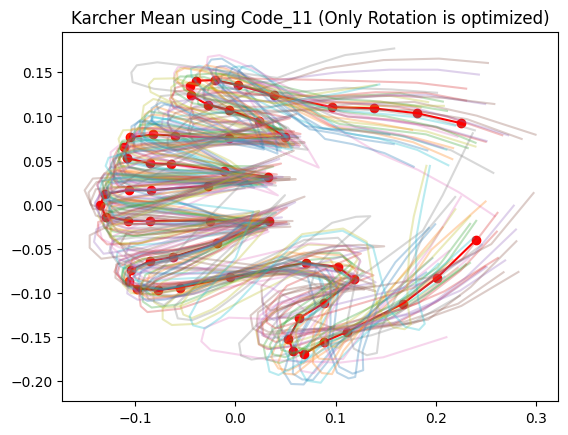

In [183]:
mean_shape=compute_karcher_mean(pointsets)
plt.plot(mean_shape[0], mean_shape[1], color='red')
plt.scatter(mean_shape[0], mean_shape[1], color='red')
for shape in pointsets:
        shape=centroid_normalize(shape)
        plt.plot(shape[0], shape[1], alpha=0.3) 
plt.title('Karcher Mean using Code_11 (Only Rotation is optimized)')

In [185]:
def compute_karcher_mean(pointsets, max_iter=30, tol=1e-6):
    pointsets_array = np.array(pointsets)  # Shape: (n_shapes, 2, 56)
    n_shape = pointsets_array.shape[0] # 40
    for i in range(n_shape):
        pointsets_array[i] = centroid_normalize(pointsets_array[i])
    mean_shape = np.mean(pointsets_array, axis=0)
    mean_shape = centroid_normalize(mean_shape)

    for iter in range(max_iter):
        aligned_shapes = []
        for i in range(n_shape):
            s, R,t = best_rotation(mean_shape, pointsets_array[i])
            aligned = s*R @ pointsets_array[i]+t
            aligned_shapes.append(aligned)

        new_mean = np.mean(np.stack(aligned_shapes), axis=0)
        new_mean = centroid_normalize(new_mean)

        diff = np.linalg.norm(new_mean - mean_shape)
        if diff < tol:
            print(f"Converged in {iter+1} iterations.")
            break
        mean_shape = new_mean

    return mean_shape

Text(0.5, 1.0, 'Karcher Mean using Code_22')

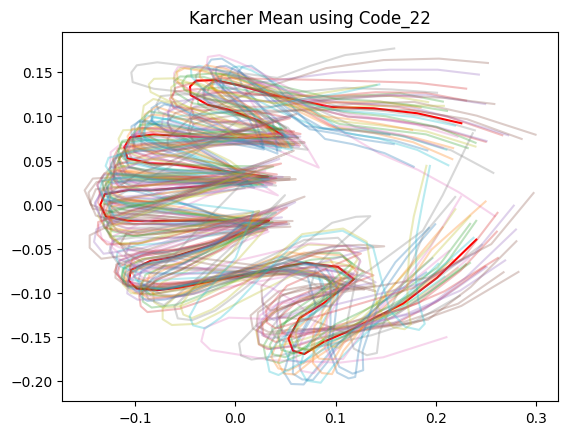

In [ ]:
mean_shape_2=compute_karcher_mean(pointsets)
plt.plot(mean_shape[0], mean_shape[1], color='red')
plt.scatter(mean_shape[0], mean_shape[1], color='red')
for shape in pointsets:
        shape=centroid_normalize(shape)
        plt.plot(shape[0], shape[1], alpha=0.3) 
plt.title('Karcher Mean using Code_22')